<!--TABLE OF CONTENTS-->
Contents:
- [Sentence embeddings](#Sentence-embeddings)
- [RAG with Langchain](#RAG-with-Langchain)

# Sentence embeddings

Sentence embeddings are numerical representations of sentences in a high-dimensional space. The goal is to capture the semantic meaning of a sentence in a dense vector. Sentences with similar meanings should have embeddings that are close to each other in this vector space.
Why are they useful?
- Semantic Similarity: Calculating how similar two sentences are in meaning.
- Clustering: Grouping similar sentences together.
- Classification: Using embeddings as features for text classification tasks.
- Information Retrieval: Finding sentences relevant to a query.

To visualize sentence embeddings we first need to install the library which provides easy access to many pre-trained models for generating sentence and text embeddings.
`pip install sentence-transformers`

In [4]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from adjustText import adjust_text

C:\ProgramData\anaconda3\envs\ml2025\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


For this example, we'll use the `all-MiniLM-L6-v2` model. It's a good general-purpose model that maps sentences to a 384-dimensional dense vector space and is known for its speed and quality.


In [6]:
model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

Let's define a list of sentences for which we want to generate embeddings.

In [8]:
sentences = [
    "The weather is sunny and warm today.",
    "It's a beautiful day with clear skies.",
    "Artificial intelligence is rapidly evolving.",  # 0
    "Machine learning models require large datasets.", # 1
    "Neural networks are inspired by the human brain.", # 2
    "The future of tech seems to be in AI.", # 3
    "The Amazon rainforest is vital for global climate.", # 4
    "Protecting endangered species is a moral imperative.", # 5
    "Climate change poses a significant threat to our planet.", # 6
    "Sustainable practices can help mitigate environmental damage.", # 7
    "I love trying new recipes on the weekend.", # 8
    "Fresh ingredients make a big difference in taste.", # 9
    "Baking bread at home is a rewarding experience.", # 10
    "What's your favorite type of cuisine?", # 11
    "Exploring new cultures broadens the mind.", # 12
    "Mountain hiking offers breathtaking views.", # 13
    "The beaches in Thailand are stunning.", # 14
    "I dream of a trip around the world.", # 15
    "What is the capital of Portugal?",
    "Lisbon is a famous city in Europe."
]
len(sentences)

20

Now, we can use the loaded model to encode these sentences into embeddings.

In [10]:
embeddings = model.encode(sentences)
embeddings.shape

(20, 384)

We see that each of the 20 sentences is represented as 384-dimensional vector. Let's just check the first few entries of one vector, to confirm it is indeed a dense, and not sparse:

In [12]:
embeddings[0][:20]

array([-0.00390334,  0.11435276,  0.11960613,  0.08374904,  0.05256062,
       -0.03919066,  0.09141209, -0.10512736, -0.05804419,  0.01511966,
        0.00562378, -0.04090554, -0.00174462,  0.04727564,  0.0993953 ,
        0.02159922, -0.03099075, -0.00087909, -0.03121787,  0.02741316],
      dtype=float32)

We can use cosine similarity to measure how similar two sentence embeddings are. A cosine equals to 1 means that the sentences are the same.
Let's calculate similarity between the first two sentences which are semantically similar, and the first and the last, which are less similar:

In [14]:
cosine_similarity(
        embeddings[0].reshape(1, -1),
        embeddings[1].reshape(1, -1)
    )

array([[0.5918906]], dtype=float32)

In [15]:
cosine_similarity(
        embeddings[0].reshape(1, -1),
        embeddings[-1].reshape(1, -1)
    )

array([[0.02293513]], dtype=float32)

We can see that the cosine similarity is close to 0 for the sentences  "The weather is sunny and warm today." and   "Lisbon is a famous city in Europe.", and it is higher for  "The weather is sunny and warm today." and "It's a beautiful day with clear skies."

Now, let's reduce the embeddings to 2 dimensions using t-SNE for visualization purpose.

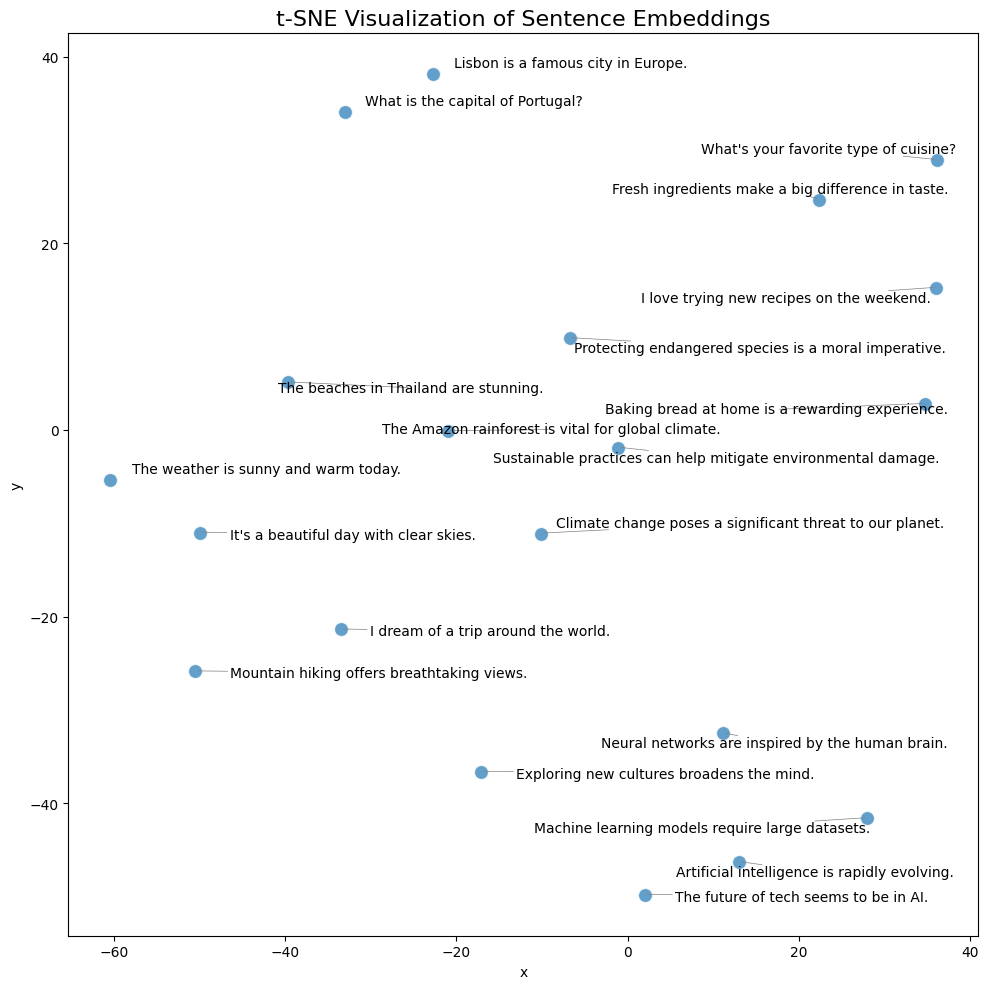

In [17]:
tsne = TSNE(n_components=2, random_state=42, perplexity=9)
embeddings_tsne = tsne.fit_transform(embeddings)
df_viz = pd.DataFrame(embeddings_tsne, columns=['x', 'y'])
df_viz['word'] = sentences
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_viz, x='x', y='y', s=100, alpha=0.7) 
texts = []
for i, point in df_viz.iterrows():
    texts.append(plt.text(point['x'] , point['y'] + 0.05, point['word'])) 
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

plt.title('t-SNE Visualization of Sentence Embeddings', fontsize=16)
plt.tight_layout()
plt.show()

Sentences that are close together in the plot are semantically more similar according to the model. However, it's important to note when we reduce data from a high-dimensional space (like the 384 dimensions of the sentence embeddings) to a very low-dimensional space (like 2D for a plot), we are losing some information in the process. While t-SNE is good at showing which points are near each other (forming clusters), the relative distances between these clusters in the 2D plot might not accurately reflect their separation in the original 384-dimensional space. Two clusters that appear far apart in the 2D t-SNE plot might not be "as far" apart in the original high-dimensional space as two other clusters that also appear far apart.

# RAG with Langchain

Retrieval Augmented Generation (RAG) is a technique for improving the responses of Large Language Models (LLMs) by providing them with external knowledge. Instead of relying solely on the information learned during its training, an LLM can access and use relevant information from a custom dataset or knowledge base at inference time.

How RAG works
- 1.  User Query: The user asks a question.
- 2.  Retrieval: The system searches a knowledge base (e.g., a collection of documents) for information relevant to the query. This often involves using vector embeddings to find semantically similar text chunks.
- 3.  Augmentation: The retrieved information (context) is added to the user's original query.
- 4.  Generation: The augmented prompt (query + context) is fed to an LLM, which then generates an answer based on both the original query and the provided context.

Benefits of RAG:
-   Reduces hallucinations by grounding the LLM in factual data.
-   Allows LLMs to use up-to-date information not present in their training data.
-   Enables LLMs to answer questions about specific domains or private data.
-   Provides a degree of explainability, as the retrieved context can be shown to the user.

We will need to install an open-source PDF library capable of splitting, merging, cropping, and transforming the pages of PDF files, and a library for Chroma vector store, which is an embedding data base. 
`pip install pypdf chromadb`

In [21]:
import os
import requests
from dotenv import load_dotenv
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain_community.llms import HuggingFaceHub

In [22]:
load_dotenv()

True

As noted in the Notebook 10, to use the models from [Hugging Face](https://huggingface.co/), you should create an account, and then create a [User Access Tokens](https://huggingface.co/settings/tokens), and copy paste to .env file as:
`HF_API_TOKEN=your-token`

For a RAG system, we need a knowledge base. This can be a collection of text files, PDFs, web pages, etc. Now let's download a 250 page pdf on Global Economic Prospects published in 2025:

In [39]:
pdf_url = "https://openknowledge.worldbank.org/server/api/core/bitstreams/f983c12d-d43c-4e41-997e-252ec6b87dbd/content"
pdf_filename = "GEP-Jan-2025.pdf"
response = requests.get(pdf_url, stream=True)
with open(pdf_filename, "wb") as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

In [40]:
loader = PyPDFLoader(pdf_filename)
documents = loader.load() 

LLMs have a context window limit. If we feed an LLM a document longer than its context window, it will either truncate the input or throw an error. PDF pages can also be long, so we split them into smaller chunks. `RecursiveCharacterTextSplitter` is a common choice. Its key idea is to try and split the text along natural semantic boundaries first (like paragraphs or lines) before resorting to more arbitrary splits (like splitting mid-sentence or by character). This helps to keep semantically related information together within the same chunk as much as possible. Its parameters are:
- chunk_size: This defines the maximum desired size usually in characters, though some splitters can work with tokens for each chunk. We will set it to 1000 characters. The splitter will try to make chunks no larger than this.
- chunk_overlap: This specifies how many characters should overlap between adjacent chunks. We will set it to 10% of the chunk size, i.e., 100. Overlapping helps to maintain context continuity. If a sentence or an important piece of information happens to fall right at the boundary where a split occurs, without overlap, that information might be cut in half, with one part in one chunk and the other in the next. The overlap ensures that a bit of text from the end of one chunk is repeated at the beginning of the next, reducing the chance of losing context at the split points. This can be very important for the retriever to find relevant information and for the LLM to understand the context properly.

In [42]:
text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=100   
    )
split_docs = text_splitter.split_documents(documents)

To perform semantic search, we need to convert our text chunks into numerical vectors (embeddings). We'll use a model from Hugging Face via `sentence-transformers`, `all-MiniLM-L6-v2` the same one we used in the first notebook section. This model runs locally and doesn't require an API key. It will download the model files the first time it's run. A vector store takes care of storing embedded data and performing vector search. There are many vector store opti5ons, and Chroma is one of them, it is free, open-source, and can run entirely on the local machine. Now, let's  create an index which contains all the information. Given that the report is 250 pages, this takes a while.

In [44]:
embedding_model_name = "sentence-transformers/all-MiniLM-L6-v2"
embeddings = HuggingFaceEmbeddings(model_name=embedding_model_name)

Vector store can run in-memory, but it also supports persistent storage to disk, making it easier to save and reload data across sessions. Note that if we run thos code below multiple times with the same persist directory, we will have duplicate vectors.

In [46]:
vector_store = Chroma.from_documents(documents=split_docs, embedding=embeddings, collection_metadata={"hnsw:space": "cosine"}, persist_directory='./rag')

To load the vector store for querying without re-adding documents, we should uncomment the following code:

In [48]:
# vector_store = Chroma( persist_directory='./rag', embedding_function=embeddings )

We can check the number of embedding vectors stored and compare it to the number of chunks we have (split_docs variable):

In [50]:
vector_store._collection.count()

1176

In [51]:
len(split_docs)

1176

The retriever is responsible for fetching relevant documents from the vector store based on a query. Let's see top 3 chunk that match a sample query:

In [53]:
retriever = vector_store.as_retriever(search_kwargs={"k": 3})
sample_query = "What are the main challenges for global trade?"
retrieved_docs_with_scores = vector_store.similarity_search_with_score(sample_query, k=3)
for i, (doc, score) in enumerate(retrieved_docs_with_scores):
    print(f"\n--- Retrieved Document {i+1} (Cosine Distance: {score:.4f}, Source Page: {doc.metadata.get('page', 'N/A')}) ---")
    print(doc.page_content[:300] + "...")


--- Retrieved Document 1 (Cosine Distance: 0.3180, Source Page: 243) ---
Globalization of trade and financial flows  
High trade costs: causes and remedies June 2021, chapter 3 
The impact of COVID-19 on global value chains June 2020, box SF1 
Poverty impact of food price shocks and policies January 2019, chapter 4 
Arm’s-length trade: A source of post-crisis trade weakn...

--- Retrieved Document 2 (Cosine Distance: 0.3283, Source Page: 58) ---
sizable investment needs with fiscal sustainability . 
More generally, structural reforms are needed to 
foster potential growth and put a wide range of 
development goals on track. These include 
measures to lessen conflict risks, boost human 
capital, bolster labor force inclusion, and address 
fo...

--- Retrieved Document 3 (Cosine Distance: 0.3497, Source Page: 148) ---
Despite EMDEs’ significant progress in 
integrating into the global economy over the past 
25 years, the global economic cooperation that 
characterized the years around t

Next, we integrate an LLM. We will use Mistral-7B-Instruct, which is a popular, efficient (~7B parameter), open-weight LLM from Mistral AI, hosted on Hugging Face.

In [55]:
llm = HuggingFaceHub(
        repo_id='mistralai/Mistral-7B-Instruct-v0.3',
        model_kwargs={"temperature": 0.1, "max_new_tokens": 300},
        huggingfacehub_api_token= os.getenv("HF_API_TOKEN")
        )

C:\Users\sabina\AppData\Local\Temp\ipykernel_19644\735099795.py:1: LangChainDeprecationWarning: The class `HuggingFaceHub` was deprecated in LangChain 0.0.21 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEndpoint``.
  llm = HuggingFaceHub(


Langchain's `RetrievalQA` chain is a common way to set up a RAG pipeline. It takes an LLM and a retriever. We can also customize the prompt template.

In [57]:
prompt_template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer from the context, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer concise. If the context is empty or irrelevant, state that you cannot answer based on the provided information.

Context: {context}

Question: {question}

Helpful Answer:"""
QA_PROMPT = PromptTemplate(
        template=prompt_template, input_variables=["context", "question"]
    )

rag_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=retriever,
        return_source_documents=True,
        chain_type_kwargs={"prompt": QA_PROMPT})

Now we can ask questions! The RAG chain will retrieve relevant documents, augment the prompt, and get the LLM to generate an answer.


In [59]:
query = "What is the projected global inflation"
result = rag_chain.invoke({"query": query})
print(result["result"])

C:\ProgramData\anaconda3\envs\ml2025\Lib\site-packages\huggingface_hub\utils\_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


Use the following pieces of context to answer the question at the end.
If you don't know the answer from the context, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer concise. If the context is empty or irrelevant, state that you cannot answer based on the provided information.

Context: C H A P T ER  1 G L O B A L  E C ON O M I C  P R O S P EC T S  |  J A N U A R Y  20 2 5 12 
  experienced a pickup in the pace of core price 
gains in the middle of last year due to accelerated  
services inflation. In some of these economies, 
wage growth and demand for services has boosted 
core prices, prompting some central banks to 
begin reassessing the pace of monetary easing. 
More recently, global core inflation began to cool 
again, partly as a result of slowing wage gains and 
weakening demand for services. Meanwhile, goods 
inflation stabilized at subdued levels, no longer 
supporting the decline in overall inflation.  
Going forw

In [60]:
query = "What are some risks to the economic outlook mentioned in the document"
result = rag_chain.invoke({"query": query})
print(result["result"])

C:\ProgramData\anaconda3\envs\ml2025\Lib\site-packages\huggingface_hub\utils\_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


Use the following pieces of context to answer the question at the end.
If you don't know the answer from the context, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer concise. If the context is empty or irrelevant, state that you cannot answer based on the provided information.

Context: uncertainty and adverse trade policy shifts in major trading partners, as well as higher commodity prices. Other 
downside risks include heightened domestic violence and social unrest, a slower pace of monetary easing and 
larger debt-service burdens, more frequent extreme weather events, and slower-than-projected growth in major 
global economies. An upside risk is stronger-than-expected growth in major economies, which would increase 
global demand and economic activity in the region. 
Note:  This section was prepared by Naotaka Sugawara.

percent in 2024 to 3.4 percent in 2025 and 4.1 percent in 2026. DT_he outlook for this year has deteri